# Import Libraries

In [ ]:
from pathlib import Path
import numpy as np
import pandas
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import datetime
now = datetime.datetime.now

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchsummary import summary
import torchvision
from torchvision import transforms
import copy

# Data Loading

In [ ]:
# Load the images
from codes.data_loader import SingleTask_DataSet

# Folder with images
imgs_folder_path = Path("data/images/")
# File with labels
labels_path = Path("data/labels.xlsx")
 
# Resize all images to 256x256 pixels
img_dim = 256
transform_img = transforms.Compose([transforms.Resize((img_dim, img_dim)), transforms.ToTensor()])

# Get the images 
BUS = SingleTask_DataSet(imgs_folder_path, transform_img, labels_path)

# Print the number of images in the dataset
num_imgs = len(BUS)
print("Number of images:", num_imgs)

# Print the images shape
print('Images shape:', BUS[0][0].shape)

Number of images: 562
Images shape: torch.Size([3, 256, 256])


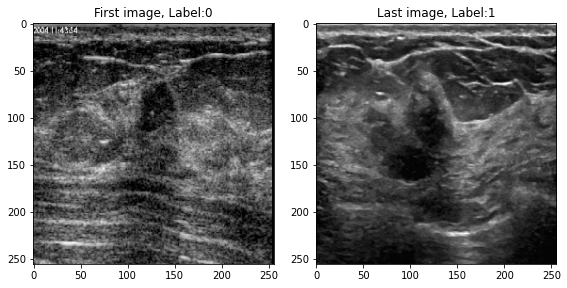

In [ ]:
# Plot the first and last images
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.imshow(np.squeeze(BUS[0][0][0]), cmap = "gray")
plt.title('First image, Label:' + str(BUS[0][1]))
plt.subplot(122)
plt.imshow(np.squeeze(BUS[-1][0][0]), cmap = "gray")
plt.title('Last image, Label:' + str(BUS[-1][1]))
plt.tight_layout()
plt.show()

# Training and Testing for One Epoch

In [ ]:
# Train the model for one epoch on the given set
def train(model, device, train_loader, criterion, optimizer, epoch):
    sum_loss, sum_correct = 0, 0

    # Switch to train mode
    model.train()

    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        # Compute the output
        output = model(data)

        # Compute the classification accuracy and loss
        loss = criterion(output, target)
        pred = output.max(1)[1]
        sum_correct += pred.eq(target).sum().item()
        sum_loss += len(data) * loss.item()

        # Compute the gradient and do an SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Return error and cross-entropy loss
    return 1 - (sum_correct / len(train_loader.dataset)), sum_loss / len(train_loader.dataset)


# Evaluate the model on the given set
def validate(model, device, val_loader, criterion):
    sum_loss, sum_correct = 0, 0
    
    # Switch to evaluation mode
    model.eval()
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device, dtype=torch.float), target.to(device)

            # Compute the output
            output = model(data)

            # Compute the classification accuracy and loss
            loss = criterion(output, target)
            pred = output.max(1)[1]
            sum_correct += pred.eq(target).sum().item()
            sum_loss += len(data) * loss.item()

    # Return error and cross-entropy loss
    return 1 - (sum_correct / len(val_loader.dataset)), sum_loss / len(val_loader.dataset)

# Model Training

In [ ]:
# Define training parameters

# Images channels and number of classes
nchannels, nclasses = 3, 2

# Other parameters
learningrate = 1e-5
batchsize = 2

# Total number of epochs
epochs = 1000

# Patience for early stopping (based on non-decreasing validation loss)
n_epochs_stop = 30

# If verbose=1 print the training and validation loss and accuracy
verbose = 0

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import the model
from codes.model import Network_SingleTask

# Import the complexity measures
from codes.complexity_measures import get_all_measures

################################################################################
Fold 1
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Early stopping!
Training time: 0:06:56.186686


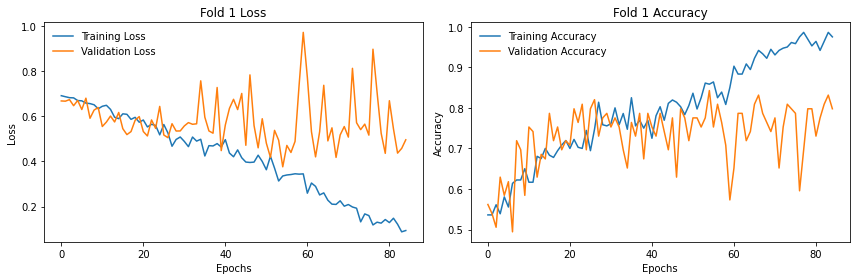


Test dataset performance: Test cross-entropy loss: 0.550 	 Test accuracy: 0.805

Calculate complexity measures!
Time for calculating the measures: 0:03:29.336324

################################################################################
Fold 2
Number of train instances: 360, Number of validation instances: 89, Number of test instances: 113

Early stopping!
Training time: 0:04:31.653769


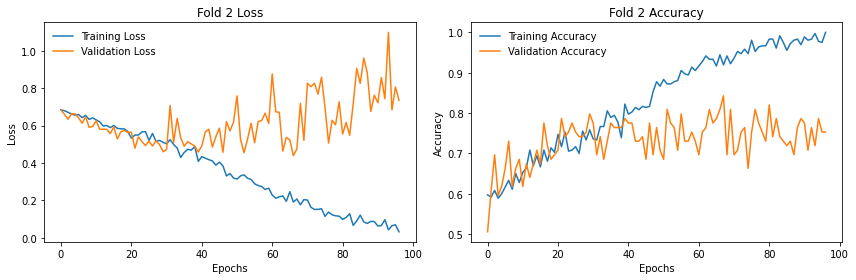


Test dataset performance: Test cross-entropy loss: 0.742 	 Test accuracy: 0.708

Calculate complexity measures!
Time for calculating the measures: 0:05:16.306788

################################################################################
Fold 3
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:04:39.709308


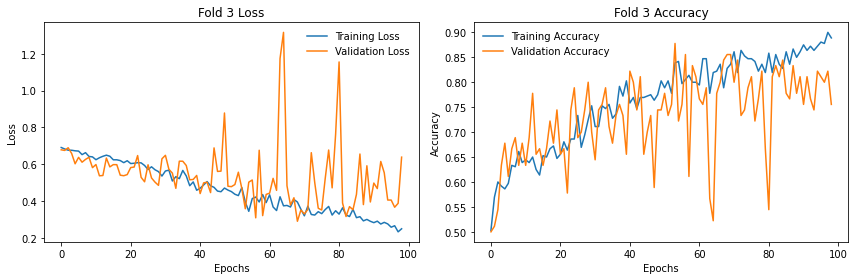


Test dataset performance: Test cross-entropy loss: 0.693 	 Test accuracy: 0.768

Calculate complexity measures!
Time for calculating the measures: 0:03:04.408599

################################################################################
Fold 4
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:03:09.854187


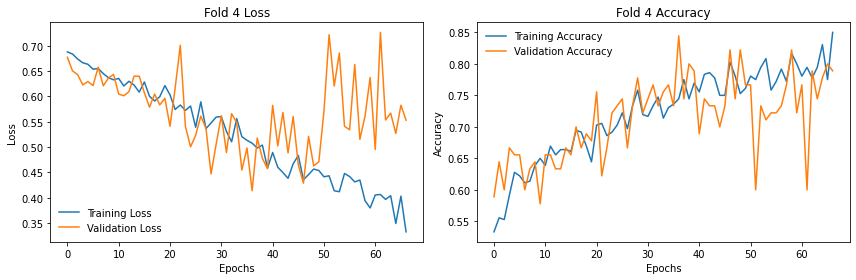


Test dataset performance: Test cross-entropy loss: 0.598 	 Test accuracy: 0.777

Calculate complexity measures!
Time for calculating the measures: 0:04:02.505559

################################################################################
Fold 5
Number of train instances: 360, Number of validation instances: 90, Number of test instances: 112

Early stopping!
Training time: 0:05:45.779675


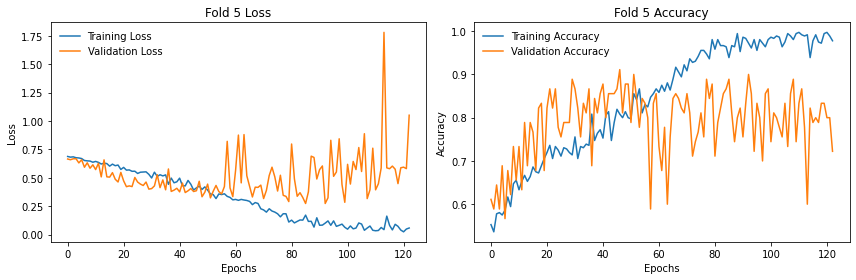


Test dataset performance: Test cross-entropy loss: 1.160 	 Test accuracy: 0.705

Calculate complexity measures!
Time for calculating the measures: 0:02:51.054263



In [ ]:
# Training with 5-fold cross-validation
n_folds = 5
kfold = KFold(n_folds, shuffle=True)

# Tensors for losses and errors
train_error = torch.zeros([n_folds], dtype=torch.float64, device=device)
train_loss = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_error = torch.zeros([n_folds], dtype=torch.float64, device=device)
test_loss = torch.zeros([n_folds], dtype=torch.float64, device=device)

for k, [train_ix, test_ix] in enumerate(kfold.split(BUS), 1):
    print('#'*80)
    print(f'Fold {k}')

    # Prepare the data for the folds
    train_fold = Subset(BUS, train_ix)
    test_fold = Subset(BUS, test_ix)

    # Number of validation instances
    n_val = int(0.2*len(train_fold))

    # Split into train and validation sets
    train_dataset, val_dataset = torch.utils.data.random_split(train_fold, [len(train_fold)-n_val, n_val])
    print(f'Number of train instances: {len(train_dataset)}, Number of validation instances: {len(val_dataset)}, Number of test instances: {len(test_ix)}\n')

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
    test_loader = DataLoader(test_fold, batch_size=batchsize, shuffle=False)

    # Keep track of cross-entropy losses and errors
    train_losses = []
    valid_losses = []
    train_errors = []
    valid_errors = []

    # Create an instance of the model
    model = Network_SingleTask(nchannels, nclasses)
    model = model.to(device)

    # Create a copy of the initial model, will be used for calculating complexity measures
    init_model = copy.deepcopy(model)

    # Define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learningrate)

    # Initialize the minimum validation loss
    min_val_loss = np.inf

    # Record the time (to report the training time)
    t = now()

    # Training the model
    for epoch in range(0, epochs):

        # Train for one epoch
        tr_err, tr_loss = train(model, device, train_loader, criterion, optimizer, epoch)

        # Evaluate after each epoch
        val_err, val_loss = validate(model, device, val_loader, criterion)

        train_losses.append(tr_loss)
        valid_losses.append(val_loss)
        train_errors.append(tr_err)
        valid_errors.append(val_err)

        # Display after each epoch
        if verbose==1:
            print(f'Epoch: {epoch + 1}/{epochs}\t Training loss: {tr_loss:.3f}\t',
                  f'Training error: {tr_err:.3f}\t Validation loss: {val_loss:.3f}\t',
                  f'Validation error: {val_err:.3f}')

        # check early stopping condition
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1

        if epoch > n_epochs_stop and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
    
    print('Training time: %s' % (now() - t))
    
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f'Fold {k} Loss')
    plt.legend(frameon=False)
    plt.subplot(122)
    plt.plot([1-x for x in train_errors], label='Training Accuracy')
    plt.plot([1-x for x in valid_errors], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f'Fold {k} Accuracy')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    train_error[k-1] = train_errors[-1]
    train_loss[k-1] = train_losses[-1]
    train_acc = 1-train_error[k-1].detach().cpu().numpy()

    # Calculate the test error and cross-entropy loss of the learned model
    test_error[k-1], test_loss[k-1] = validate(model, device, test_loader, criterion)
    print(f'\nTest dataset performance: Test cross-entropy loss: {test_loss[k-1]:.3f} \t Test accuracy: {1-test_error[k-1]:.3f}\n')
    
    ################################################################
    # Calculate complexity measures
    print("Calculate complexity measures!")
    
    # Record the time
    t = now()

    globals()['train_measures_'+str(k-1)] = {};
    globals()['train_measures_'+str(k-1)] = get_all_measures(model, init_model, train_loader, train_acc, seed=0)

    print('Time for calculating the measures: %s\n' % (now() - t))

In [ ]:
folds_list = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# Display the train and test errors for all 5 folds in a pandas DataFrame
all_errors = pandas.DataFrame({'Train Error': train_error.detach().cpu().numpy(), 'Test Error': test_error.detach().cpu().numpy()}, index = folds_list) 
all_errors

,Train Error,Test Error
Fold 1,0.025000,0.194690
Fold 2,0.000000,0.292035
Fold 3,0.111111,0.232143
Fold 4,0.150000,0.223214
Fold 5,0.022222,0.294643


In [ ]:
# Display the calculated complexity measures for all 5 folds in a pandas DataFrame
all_measures = pandas.DataFrame([train_measures_0, train_measures_1, train_measures_2, train_measures_3, train_measures_4], index = folds_list)
all_measures

,ComplexityType.L2,ComplexityType.L2_DIST,ComplexityType.PARAMS,ComplexityType.INVERSE_MARGIN,ComplexityType.LOG_PROD_OF_SPEC,ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SPEC_INIT_MAIN,ComplexityType.FRO_OVER_SPEC,ComplexityType.LOG_SPEC_ORIG_MAIN,ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN,ComplexityType.LOG_SUM_OF_SPEC,ComplexityType.LOG_PROD_OF_FRO,ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN,ComplexityType.LOG_SUM_OF_FRO,ComplexityType.FRO_DIST,ComplexityType.DIST_SPEC_INIT,ComplexityType.PARAM_NORM,ComplexityType.PATH_NORM,ComplexityType.PATH_NORM_OVER_MARGIN,ComplexityType.PACBAYES_INIT,ComplexityType.PACBAYES_ORIG,ComplexityType.PACBAYES_FLATNESS,ComplexityType.PACBAYES_MAG_INIT,ComplexityType.PACBAYES_MAG_ORIG,ComplexityType.PACBAYES_MAG_FLATNESS
Fold 1,0.556893,0.497400,116.187205,0.015930,33.514445,32.317927,34.966830,1.311033,35.531794,0.157781,0.209804,54.984682,53.788164,1.091270,1.143292,4.694215,2.141960,5.884294,4.677263,1.413679,26.705822,33.475857,0.599662,149.084633,154.112405,0.374788
Fold 2,0.530443,0.461156,116.187205,0.013079,33.772776,32.379092,34.991186,1.272179,35.562876,0.160440,0.221036,54.769991,53.376307,1.073363,1.133958,4.035037,2.031427,5.338618,3.793968,0.941509,22.703748,30.037910,0.593072,146.766935,153.065182,0.405595
Fold 3,0.503945,0.419007,116.187205,0.038087,33.772036,33.447195,36.075594,1.285574,36.641451,0.206880,0.221003,54.777087,54.452246,1.120143,1.134266,3.331146,1.643819,4.818566,3.789522,2.738475,21.320536,30.839653,0.674619,141.782198,150.305753,0.396835
Fold 4,0.549341,0.484918,116.187205,0.062751,33.160731,33.335196,35.995192,1.346702,36.575907,0.202010,0.194425,55.080206,55.254671,1.155031,1.147445,4.461578,1.926659,5.725796,5.188918,6.177971,35.693352,45.806939,0.843274,147.205563,152.815284,0.402570
Fold 5,0.505273,0.423586,116.187205,0.030969,34.092516,33.560789,36.181387,1.260099,36.735033,0.211818,0.234937,54.581000,54.049273,1.102622,1.125741,3.404359,1.663377,4.843986,3.150515,1.851210,27.235821,38.752554,0.843274,145.555368,153.508623,0.586625


# Calculate Kendall's Correlation Coefficients 

Note: the number of used models is low; it is required to run many more models to obtain reliable correlations

In [ ]:
test_error = all_errors['Test Error']
train_error = all_errors['Train Error']

In [ ]:
import scipy.stats as stats

# Kendall's rank-correlation coefficients
print('Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):\n')
for i in range(all_measures.shape[1]):
    tau_gen_gap, p_value = stats.kendalltau(test_error-train_error, all_measures.iloc[:,i])
    print(all_measures.columns[i], '\t\t', tau_gen_gap)

Correlations Between Compexity Measures and Generalization Gap (Test Error-Train Error):

ComplexityType.L2 		 0.0
ComplexityType.L2_DIST 		 0.0
ComplexityType.PARAMS 		 nan
ComplexityType.INVERSE_MARGIN 		 -0.7999999999999999
ComplexityType.LOG_PROD_OF_SPEC 		 0.6
ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN 		 0.0
ComplexityType.LOG_SPEC_INIT_MAIN 		 0.0
ComplexityType.FRO_OVER_SPEC 		 -0.6
ComplexityType.LOG_SPEC_ORIG_MAIN 		 0.0
ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN 		 0.0
ComplexityType.LOG_SUM_OF_SPEC 		 0.6
ComplexityType.LOG_PROD_OF_FRO 		 -0.6
ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN 		 -0.7999999999999999
ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN 		 -0.7999999999999999
ComplexityType.LOG_SUM_OF_FRO 		 -0.6
ComplexityType.FRO_DIST 		 0.0
ComplexityType.DIST_SPEC_INIT 		 0.19999999999999998
ComplexityType.PARAM_NORM 		 0.0
ComplexityType.PATH_NORM 		 -0.39999999999999997
ComplexityType.PATH_NORM_OVER_MARGIN 		 -0.7999999999999999
ComplexityType.PACBAYES_INIT 		 -0.1999999

In [ ]:
# Kendall's rank-correlation coefficients
print('Correlations Between Compexity Measures and Test Error:\n')
for i in range(all_measures.shape[1]):
    tau_test_error, p_value = stats.kendalltau(test_error, all_measures.iloc[:,i])
    print(all_measures.columns[i], '\t\t', tau_test_error)

Correlations Between Compexity Measures and Test Error:

ComplexityType.L2 		 -0.6
ComplexityType.L2_DIST 		 -0.6
ComplexityType.PARAMS 		 nan
ComplexityType.INVERSE_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_PROD_OF_SPEC 		 0.7999999999999999
ComplexityType.LOG_PROD_OF_SPEC_OVER_MARGIN 		 0.6
ComplexityType.LOG_SPEC_INIT_MAIN 		 0.6
ComplexityType.FRO_OVER_SPEC 		 -0.7999999999999999
ComplexityType.LOG_SPEC_ORIG_MAIN 		 0.6
ComplexityType.LOG_SUM_OF_SPEC_OVER_MARGIN 		 0.6
ComplexityType.LOG_SUM_OF_SPEC 		 0.7999999999999999
ComplexityType.LOG_PROD_OF_FRO 		 -0.7999999999999999
ComplexityType.LOG_PROD_OF_FRO_OVER_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_SUM_OF_FRO_OVER_MARGIN 		 -0.19999999999999998
ComplexityType.LOG_SUM_OF_FRO 		 -0.7999999999999999
ComplexityType.FRO_DIST 		 -0.6
ComplexityType.DIST_SPEC_INIT 		 -0.39999999999999997
ComplexityType.PARAM_NORM 		 -0.6
ComplexityType.PATH_NORM 		 -0.6
ComplexityType.PATH_NORM_OVER_MARGIN 		 -0.19999999999999998
Complex

# Print the Model

In [ ]:
# Display the layers
print(model)

Network_SingleTask(
  (Conv_Block_1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv_Block_2): DownConv(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (block): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, 

In [ ]:
# Summary of the feature maps at each layer
summary(model, input_size=(nchannels, img_dim, img_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
        DoubleConv-7         [-1, 32, 256, 256]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1